In [12]:
#!pip install tensorflow
#!pip install mlflow

import mlflow
import pandas as pd
import numpy as np
import unittest
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [2]:
# Utilizado o dataset do kaggle https://www.kaggle.com/datasets/ashaychoudhary/heart-attack-in-japan-youth-vs-adult
data = pd.read_csv("japan_heart_attack_dataset.csv")
df = data.drop_duplicates()
columns_to_drop = [col for col in df.columns if col.startswith('Extra_Column')]
df = df.drop(columns=columns_to_drop)
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      30000 non-null  int64  
 1   Gender                   30000 non-null  object 
 2   Region                   30000 non-null  object 
 3   Smoking_History          30000 non-null  object 
 4   Diabetes_History         30000 non-null  object 
 5   Hypertension_History     30000 non-null  object 
 6   Cholesterol_Level        30000 non-null  float64
 7   Physical_Activity        30000 non-null  object 
 8   Diet_Quality             30000 non-null  object 
 9   Alcohol_Consumption      26985 non-null  object 
 10  Stress_Levels            30000 non-null  float64
 11  BMI                      30000 non-null  float64
 12  Heart_Rate               30000 non-null  float64
 13  Systolic_BP              30000 non-null  float64
 14  Diastolic_BP          

,Age,Gender,Region,Smoking_History,Diabetes_History,Hypertension_History,Cholesterol_Level,Physical_Activity,Diet_Quality,Alcohol_Consumption,Stress_Levels,BMI,Heart_Rate,Systolic_BP,Diastolic_BP,Family_History,Heart_Attack_Occurrence
0,56,Male,Urban,Yes,No,No,186.400209,Moderate,Poor,Low,3.644786,33.961349,72.301534,123.902090,85.682809,No,No
1,69,Male,Urban,No,No,No,185.136747,Low,Good,Low,3.384056,28.242873,57.457640,129.893306,73.524262,Yes,No
2,46,Male,Rural,Yes,No,No,210.696611,Low,Average,Moderate,3.810911,27.601210,64.658697,145.654901,71.994812,No,No
3,32,Female,Urban,No,No,No,211.165478,Moderate,Good,High,6.014878,23.717291,55.131469,131.785220,68.211333,No,No
4,60,Female,Rural,No,No,No,223.814253,High,Good,High,6.806883,19.771578,76.667917,100.694559,92.902489,No,No


Gender
Male      15067
Female    14933
Name: count, dtype: int64
Heart_Attack_Occurrence
No     27036
Yes     2964
Name: count, dtype: int64


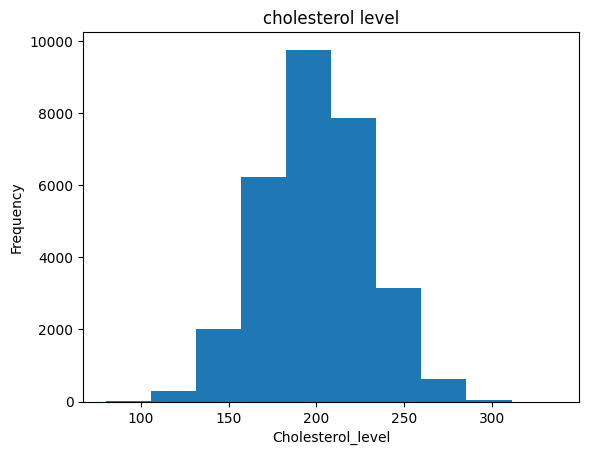

In [3]:
df['Cholesterol_Level'].plot(kind='hist')

plt.title("cholesterol level")
plt.xlabel("Cholesterol_level")
plt.ylabel('Frequency')

print(df['Gender'].value_counts())
print(df['Heart_Attack_Occurrence'].value_counts())


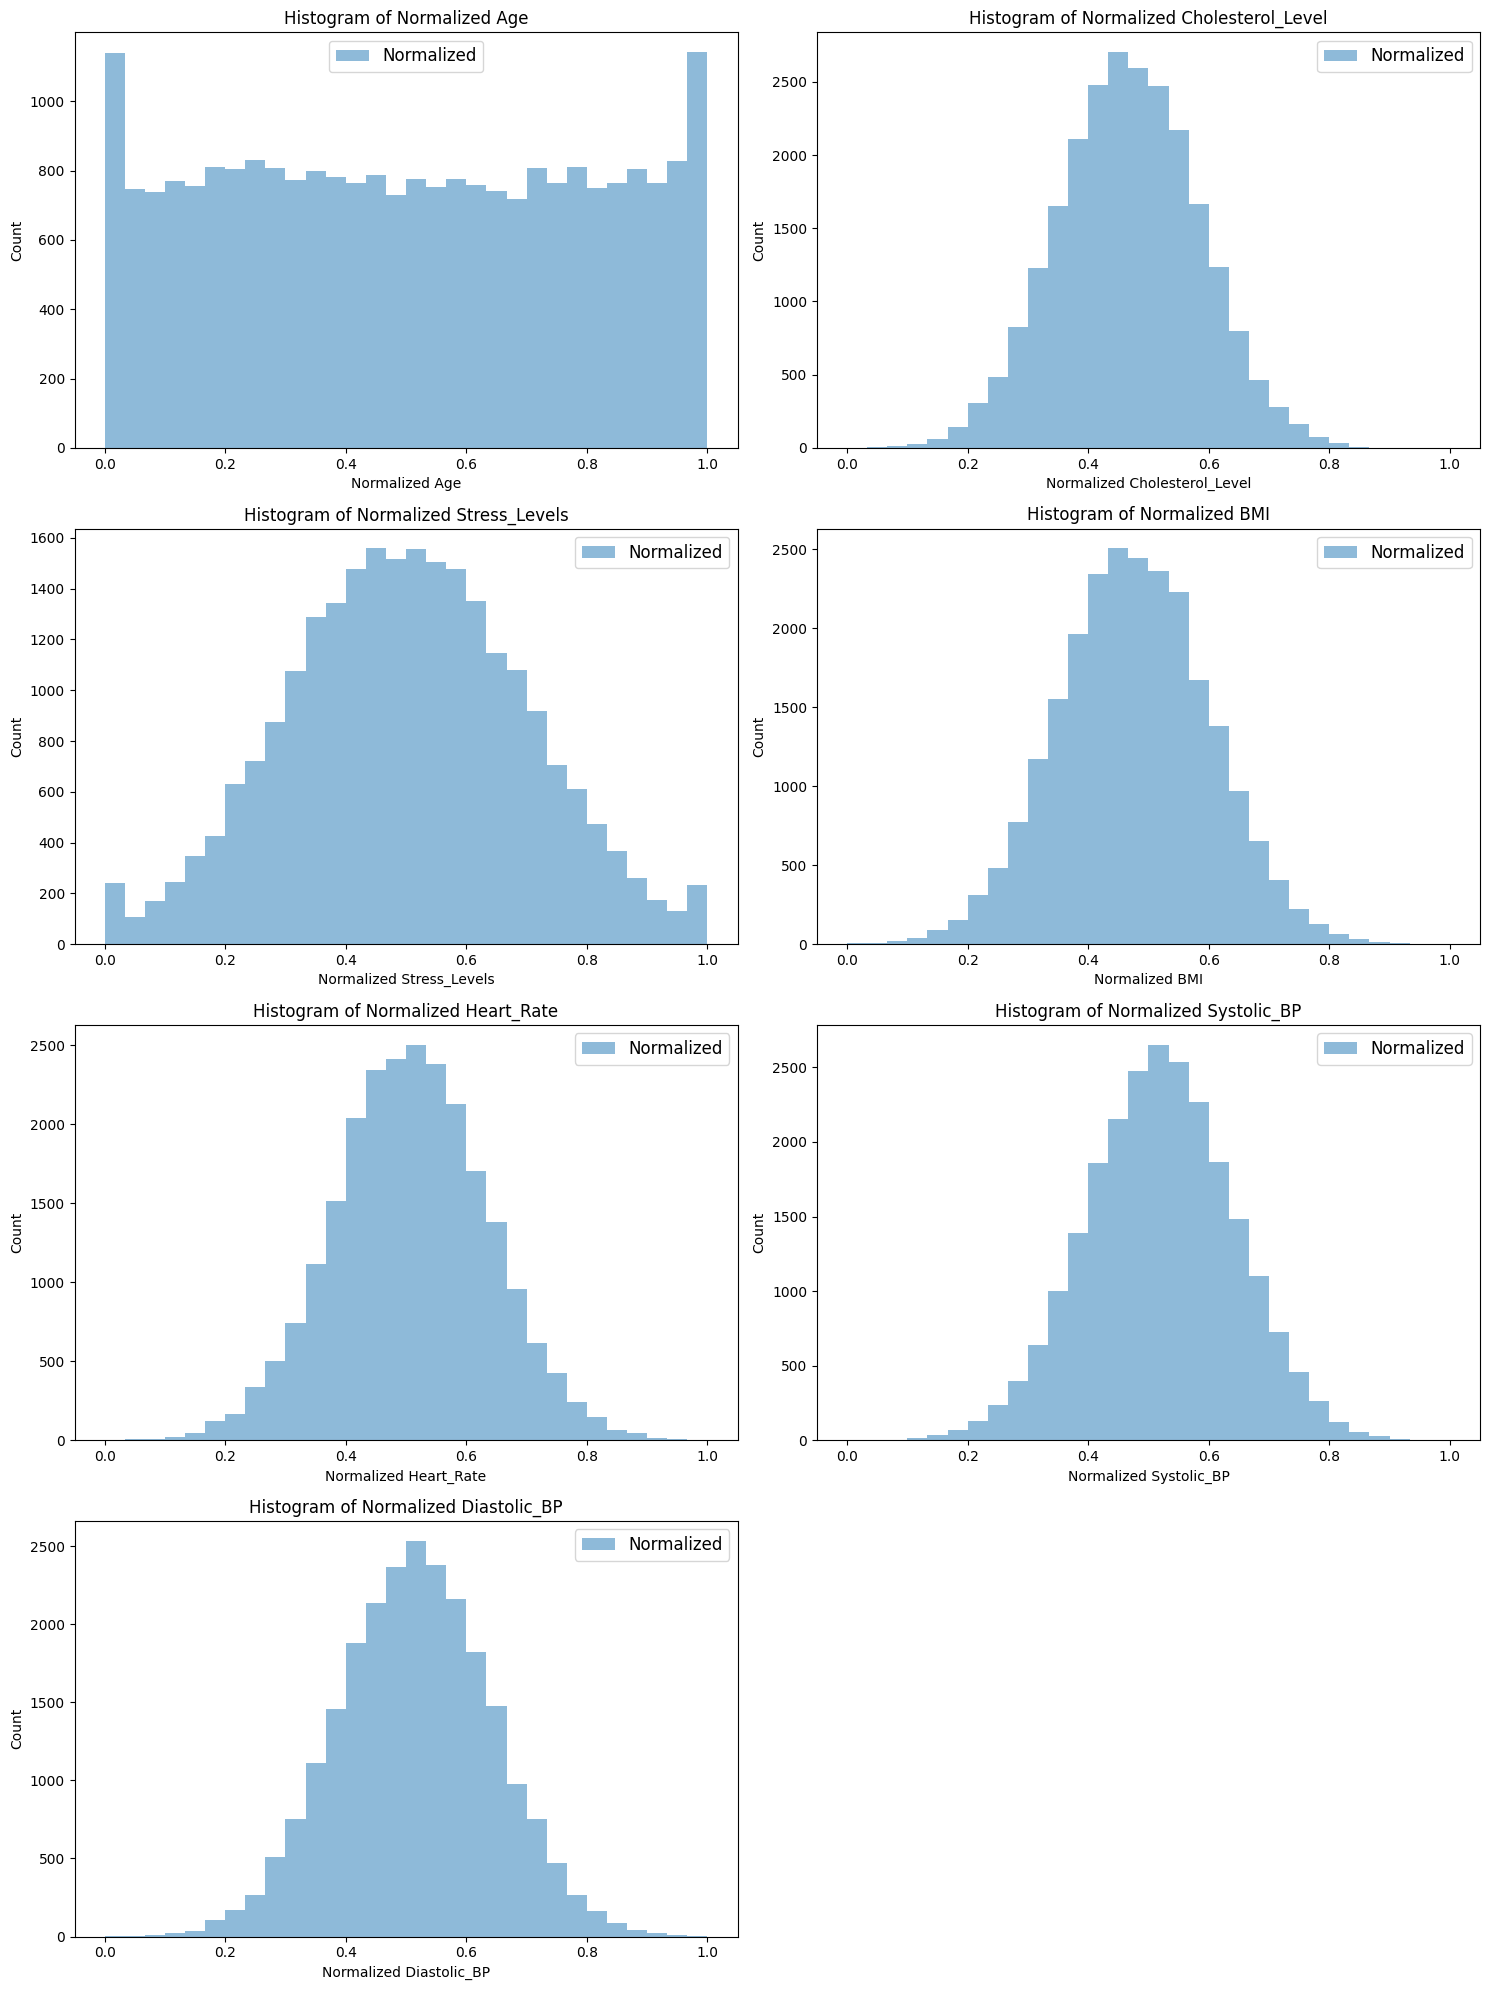

In [5]:
y = df['Heart_Attack_Occurrence']
df = df.drop('Heart_Attack_Occurrence', axis=1)

categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
y = pd.get_dummies(y, columns=categorical_columns,drop_first=True)

X_train, X_test, Y_train, Y_test = train_test_split(df, y, test_size=0.2, random_state=42)

columns_to_normalize = X_train.select_dtypes(include=[np.number]).columns.tolist()
normalizer = MinMaxScaler(feature_range=(0, 1))
X_train[columns_to_normalize] = normalizer.fit_transform(X_train[columns_to_normalize])
X_test[columns_to_normalize] = normalizer.transform(X_test[columns_to_normalize])

n_cols = len(columns_to_normalize)
n_rows = (n_cols + 1) // 2

plt.figure(figsize=(15, 5 * n_rows))
for i, column in enumerate(columns_to_normalize, 1):
    plt.subplot(n_rows, 2, i)
    plt.hist(X_train[column], bins=30, alpha=0.5, label='Normalized')
    plt.legend(prop={'size': 12})
    plt.title(f'Histogram of Normalized {column}')
    plt.xlabel(f'Normalized {column}')
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

print("Conjunto de treino normalizado:")
print(X_train)

print("\nConjunto de teste normalizado:")
print(X_test)


In [6]:
# print(X_train.dtypes)
# print(Y_test, Y_train)

svc_model = SVC(kernel='linear')
svc_model.fit(X_train, Y_train)

# Get predictions from the model
y_pred = svc_model.predict(X_test)
print(y_pred)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[False False False ... False False False]


In [8]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
Y_train = Y_train.astype(np.float32)
Y_test = Y_test.astype(np.float32)

In [10]:
mlflow.set_experiment("Logistic Regression Heart Disease Prediction")

with mlflow.start_run():
  # Definir a rede neural
  model = Sequential()


  model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
  model.add(Dense(32, activation='relu'))  # Utilização da função de ativação relu na camada oculta
  model.add(Dense(1, activation='sigmoid')) # como é uma classificação binária utilizou-se uma função de ativação binaria na saída

  #Definição dos hiperparâmetros do mlflow
  mlflow.log_param("optimizer", "adam")
  mlflow.log_param("learning_rate", 0.001)
  mlflow.log_param("epochs", 50)
  mlflow.log_param("batch_size", 32)

  model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
  model.summary()
  history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
  loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
  print(f"Acurácia no conjunto de teste: {accuracy:.4f}")

  mlflow.log_metric("loss", loss)
  mlflow.log_metric("accuracy", accuracy)

  # previsões
  y_pred = model.predict(X_test)
  y_pred = (y_pred > 0.5).astype(int)


  mlflow.keras.log_model(model, "model")



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 64)                  │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,393 (13.25 KB)

 Trainable params: 3,393 (13.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8579 - loss: 0.3844 - val_accuracy: 0.8994 - val_loss: 0.3278
Epoch 2/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9056 - loss: 0.3134 - val_accuracy: 0.8994 - val_loss: 0.3282
Epoch 3/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9008 - loss: 0.3239 - val_accuracy: 0.8994 - val_loss: 0.3271
Epoch 4/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9012 - loss: 0.3224 - val_accuracy: 0.8994 - val_loss: 0.3272
Epoch 5/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9037 - loss: 0.3166 - val_accuracy: 0.8994 - val_loss: 0.3271
Epoch 6/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9020 - loss: 0.3198 - val_accuracy: 0.8994 - val_loss: 0.3272
Epoch 7/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9038 - loss: 0.3159 - val_accuracy: 0.8994 - val_loss: 0.3283
Epoch 8/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8982 - loss: 0.3261 - val_accuracy: 0.

2025/02/10 09:08:49 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/02/10 09:09:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [24]:
class TestModelInference(unittest.TestCase):
	def setUp(self):
		self.model = model

		# set X_test as a class attribute
		self.X_test = X_test

	# define a test for prediction output values
	def test_prediction_output_values(self):
		print("Running test_prediction_output_values test case")

		# Get model predictions
		y_pred = self.model.predict(self.X_test)
		unique_values = np.unique(y_pred)
		for value in unique_values:
			self.assertIn(value, [0, 1])

In [26]:
# Dockerfile para conteinerizar o código
# Usa uma imagem oficial do Python como base
#FROM python:3.9

# Define o diretório de trabalho dentro do contêiner
#WORKDIR /app

# Copia os arquivos do projeto para o contêiner
#COPY . .

# Instala as dependências do projeto
#RUN pip install --no-cache-dir -r requirements.txt

# Define a variável de ambiente para desativar buffering no output do Python
#ENV PYTHONUNBUFFERED=1

# Comando para rodar o script principal
#CMD ["python", "seu_script.py"]

#Crie um requiriments.txt para que o o docker instale as dependências automaticamente
#tensorflow
#mlflow
#pandas
#numpy
#matplotlib
#scikit-learn

#para construir a imagem Docker no terminal, execute:
#docker build -t meu_modelo_ml .

# Rodar o container
# docker run -it meu_modelo_ml
